Here, we want to know the model with the best explanatory power.

## Requirements

```bash

mamba create -n acnets_bambi
mamba activate acnets_bambi
mamba install python ipykernel
pip install watermark bambi xarray netcdf4 seaborn
# pip install bokeh
```

In [1]:
import bambi
import arviz as az
import xarray as xr
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
grid_results = pd.read_csv('data/classification_results/grid_results.csv', index_col=0)

grid_results['label'] = grid_results['param_extract__kind'] + ' (' + grid_results['param_extract__frequency_band'] + ')'

# Sift out the best params (C and feature selections) for each model
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx]
grid_results.drop_duplicates(subset='label', inplace=True)

split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')

grid_results = grid_results[['param_extract__frequency_band', 'param_extract__kind', 'test_score']]
grid_results.rename(columns={'param_extract__frequency_band': 'band',
                       'param_extract__kind': 'kind'},
                        inplace=True)
grid_results[['input_type', 'source']] = grid_results['kind'].apply(lambda x: x.split(' ')).apply(pd.Series)
grid_results['source'] = grid_results['source'].apply(lambda x: x.replace('source', 'region'))

grid_results['source'] = grid_results['source'].astype('category')
grid_results['input_type'] = grid_results['input_type'].astype('category')
grid_results['band'] = grid_results['band'].astype('category')
grid_results.drop(columns='kind', inplace=True) # drop to prevent confusion

In [48]:
model = bambi.Model('test_score ~ band * input_type * source', grid_results)
fitted2 = model.fit(tune=50, draws=100, chains=2)

az.summary(fitted2).sort_values('mean', ascending=False)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Intercept, band, input_type, band:input_type, source, band:source, input_type:source, band:input_type:source, test_score_sigma]


/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yeganeh/miniconda3/envs/otka/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 50 tune and 100 draw iterations (100 + 200 draws total) took 1724 seconds.
The acceptance probability does not match the target. It is 0.9148, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9223, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,20.915,0.327,20.300,21.500,0.033,0.023,97.0,83.0,1.03
"band:source[delta, sensor]",5.905,0.674,4.669,7.012,0.081,0.058,70.0,139.0,1.02
"band:input_type:source[beta, power, sensor]",5.030,0.948,3.445,6.958,0.101,0.072,88.0,131.0,1.01
test_score_sigma,4.562,0.040,4.495,4.644,0.004,0.003,109.0,156.0,1.02
"band:input_type[delta, power]",3.428,0.655,2.080,4.478,0.067,0.048,95.0,151.0,1.02
"band:source[theta, sensor]",3.288,0.616,2.172,4.369,0.087,0.062,61.0,63.0,1.04
"band:input_type[delta, plv]",3.258,0.696,2.108,4.506,0.091,0.065,55.0,132.0,1.05
band[beta],3.072,0.460,2.182,3.804,0.036,0.026,167.0,156.0,1.00
"band:input_type[gamma, power]",2.965,0.619,1.621,3.963,0.067,0.047,90.0,99.0,1.00
"band:input_type[theta, plv]",2.931,0.645,1.596,3.970,0.076,0.054,79.0,142.0,1.03


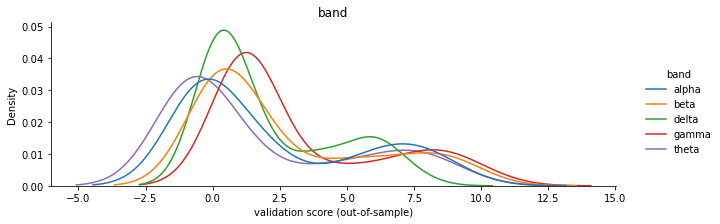

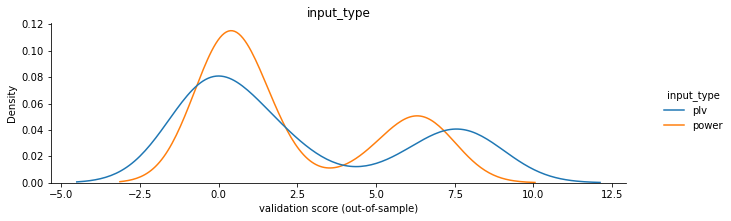

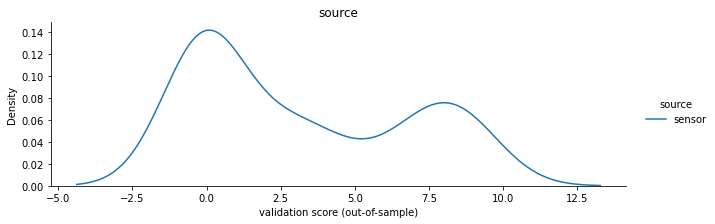

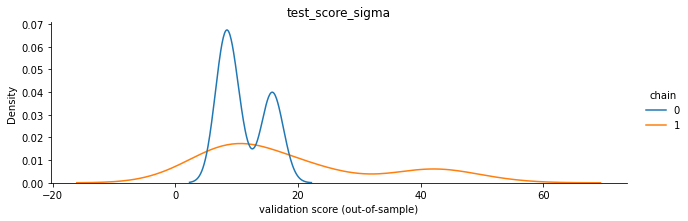

In [45]:
for i, var_name in enumerate(fitted['posterior'].data_vars):
    plot_data = fitted['posterior'][var_name].to_dataframe().reset_index()
    hue_dim = 0 if 'test_score_sigma' in var_name or 'Intercept' in var_name else 2
    g = sns.displot(data=plot_data,
                    x=var_name,
                    kind='kde',
                    aspect=3,
                    height=3,
                    hue=fitted['posterior'][var_name].dims[hue_dim],
                    # height=2, aspect=2,
                    )
    g.set(xlabel='validation score (out-of-sample)')
    g.set(title=var_name)
    g.legend.set_title(g.legend.get_title().get_text().replace('_dim',''))

    plt.show()


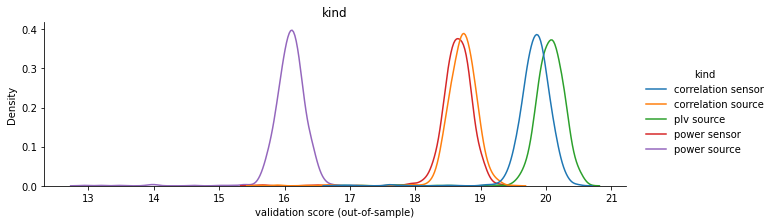

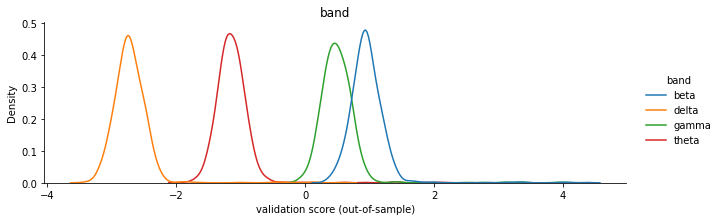

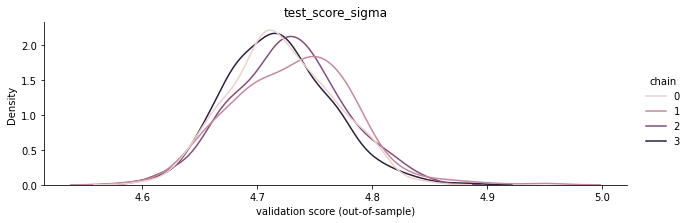

In [5]:
for i, var_name in enumerate(fitted['posterior'].data_vars):
    plot_data = fitted['posterior'][var_name].to_dataframe().reset_index()
    hue_dim = 0 if 'test_score_sigma' in var_name or 'Intercept' in var_name else 2
    g = sns.displot(data=plot_data,
                    x=var_name,
                    kind='kde',
                    aspect=3,
                    height=3,
                    hue=fitted['posterior'][var_name].dims[hue_dim],
                    # height=2, aspect=2,
                    )
    g.set(xlabel='validation score (out-of-sample)')
    g.set(title=var_name)
    g.legend.set_title(g.legend.get_title().get_text().replace('_dim',''))

    plt.show()


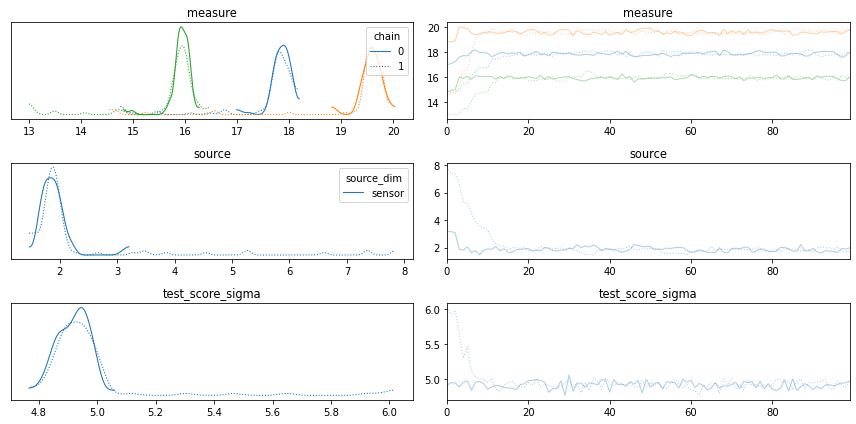

In [10]:
az.plot_trace(fitted, legend=True)

plt.tight_layout()
plt.show()

In [37]:
# save InferenceData
from pathlib import Path
path = Path('data/inference_data/')
fitted.to_netcdf(path/'model_with_interaction.nc')

# load InferenceData
# fitted_data = az.from_netcdf(path/'model_with_interaction.nc')

In [51]:
# compare models
model_dict = {'with_interaction': fitted2,
              'without_interaction': fitted}

az.compare(model_dict)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
with_interaction,0,-17634.936404,31.638888,0.000000,1.000000e+00,55.377429,0.000000,False,log
without_interaction,1,-18244.768781,9.257546,609.832377,2.196509e-08,55.233296,35.170395,False,log


In [ ]:
# Model structure